# Lab 6 [Optional] -- Random Graphs: Community Detection


#### Authors:

v1.0 (2015 Fall) Kabir Chandrasekher \*\*, Max Kanwal \*\*,  Dong Yin\*\*, Kangwook Lee \*\*, Kannan Ramchandran \*\* <br/>
v1.1 (2016 Spring) Kabir Chandrasekher, Tony Duan, David Marn, Ashvin Nair, Kangwook Lee, Kannan Ramchandran

The purpose of this lab is to provide supplementary for community detection using the **Stochastic Block Model** (SBM).

The first section of the lab explores the SBM and usage of MLE to find the min-bisection to recover communities -- this overlaps with material you've already completed for Lab 8. To jump to the new material covering the proof of recovery threshold, [click here](#Thresholds-on-Exact-Recovery:-When-Will-MLE-Correctly-Recover-the-Communities?) (also see the Table of Contents below).

Recall that we are trying to be able to deal with communities such as:
<img src="https://camo.githubusercontent.com/39cd6fdba4a8e2ba611f578b12a79c0785a212fa/68747470733a2f2f646174612e677261706873747265616d2d70726f6a6563742e6f72672f74616c6b732f43535353323031322f6d656469612f436f6d6d756e6974795f537472756374757265322e6a7067" width="300" height="300" />

### Table of Contents:
- Introduction
- Some Helpful Code
- MLE and the Min-Bisection Problem
    - Question 0: A Proof of the Reduction
    - Question 1: Playing with MLE
- Thresholds on Exact Recovery: When Will MLE Correctly Recover the Communities?
    - Question 2: A Proof of the Lower Bound on Recovery
- Efficient Algorithm for Community Detection
    - Question 3: Simulating Efficient Recovery

----------------------------------------------------------------------------------------------------------------------

## A Brief Introduction to the Stochastic Block Model

Let's revisit the Berkeley/Stanford example.  Let's say there's an equal number of students at Berkeley and at Stanford, and we have a graph with nodes representing students edges representing friendships between students.  The problem we would like to solve is: given such a graph, can we determine which students are part of the same community? We may not be able to determine which community is which, but we would like to be able to determine which students are in the same community.  

In the stochastic block model (let's call it SBM), we have graphs of the form $G(n,p,q)$ (for simplicity, let's assume $n$ is even and $p>q$).  In this model, we have two "communities" each of size $\frac{n}{2}$ such that the probability of an edge existing between any two nodes within a community is $p$ and the probability of an edge between the two communities is $q$.  We are interested in recovering the communities from a realization of the random graph.  First, let's visualize these community graphs and try to observe some phase transitions.

## Some Helpful Functions
### Helper Functions for Graphs:

In [2]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
from __future__ import division
from cvxopt import matrix, solvers, log
import numpy as np
from numpy import zeros, random, transpose, argsort, array
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

rcParams['figure.figsize'] = 12, 12  # that's default image size for this interactive session

def draw_graph(graph, labels=None, graph_layout='shell',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    We describe a graph as a list enumerating all edges.
    Ex: graph = [(1,2), (2,3)] represents a graph with 2 edges - (node1 - node2) and (node2 - node3)
    """
    
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()
    
def find_connected_component(graph, starting_node):
    """
    Return the connected component containing a given starting node
    """
    connected_nodes = set()
    connected_nodes.add( starting_node )
    changed_flag = True
    while changed_flag:
        changed_flag = False
        for node1,node2 in graph:
            if (node1 in connected_nodes and node2 not in connected_nodes) or \
                (node1 not in connected_nodes and node2 in connected_nodes):
                connected_nodes.add(node1)
                connected_nodes.add(node2)
                changed_flag = True
    return connected_nodes

def connected_components(graph):
    """
    Return a list of connected_components
    """
    nodes = set()
    components = []
    for edge in graph:
        for node in edge:
            nodes.add(node)
    flag = False
    for node in nodes:
        for component in components:
            if node in component:
                flag = True
                break
        if not flag:
            components.append(find_connected_component(graph,node))
        flag = False
    return components

#Return a list of the sizes of all the connected components
component_sizes = lambda graph: [len(component) for component in (connected_components(graph))]

#Return the largest connected component in the graph
largest_component_size = lambda graph: max(component_sizes(graph))

### Helper Functions for Semi-definite Programming:

In [8]:
solvers.options['show_progress'] = False

def generate_sbm(n, alpha, beta):
    """
    Generate the A matrix for an SBM.
    inputs:  n: total number of nodes, 
             alpha: parameter alpha corresponding to the in-cluster connection probability
             beta: parameter beta corresponding to the cross-cluster connection probability
    outputs: A: the "A" matrix for the SBM. A(i,i)=0 for all i; A(i,j) = 1 if (i,j) is an edge; A(i,j)=-1 otherwise.
             truth: the ground truth of the two clusters, represented with +/- 1
    both A and truth are in the CVX matrix data structure 
    """
    assert(n % 2 == 0)
    mid = int(n/2)
    # generate parameters
    p = alpha*log(n)/n
    q = beta*log(n)/n
    # generate A matrix
    A = zeros([n, n])
    A[0:mid, mid:n] = random.binomial(1, q, (mid, mid))
    for i in range(mid):
        for j in range(i+1, mid):
            A[i, j] = random.binomial(1, p)
    for i in range(mid, n):
        for j in range(i+1, n):
            A[i, j] = random.binomial(1, p)
    A = A+transpose(A)
    A = (A-0.5)*2
    for i in range(n):
        A[i, i] = 0
    # randomly permute the rows and columns
    perm = random.permutation(n)
    A = A[:, perm]
    A = A[perm, :]
    # find the ground truth
    argperm = argsort(perm)
    truth = zeros([n, 1])
    truth[argperm[0:mid], 0] = 1
    truth[argperm[mid:n], 0] = -1
    # return A and truth
    return matrix(A), matrix(truth)

def is_correct(sol, truth):
    """
    Checks whether the reconstruction found by SDP is correct.
    inputs:  sol: the solution X^* found by SDP in CVX matrix data structure
             truth: ground truth x^*, a column vector in CVX matrix data structure
    outputs: 1 if reconstruction is correct; 0 otherwise
    """
    # set a threshold for the difference between elements of X^* and x^*X^{*T}
    th = 1e-4
    difference = abs(sol-truth*transpose(truth))
    if difference.max() < th:
        # exact recovery
        return 1
    else:
        # wrong recovery
        return 0

def recon_prob_sdp(n, alpha, beta):
    """
    Find the probability of successful reconstruction given the parameters
    inputs:  n: total number of nodes, 
             alpha: parameter alpha corresponding to the in-cluster connection probability
             beta: parameter beta corresponding to the cross-cluster connection probability
    outputs: the simulated probability of successful reconstruction
    """
    assert(n % 2 == 0)
    num_tests = 50
    num_success = 0.0
    for t in range(num_tests):
        result = generate_sbm(n, alpha, beta)
        A = result[0]
        truth = result[1]

        # Set parameters for the SDP
        c = matrix(-1., (n, 1))
        h = [-A]
        G1 = zeros([n*n, n])
        for i in range(n):
            G1[i+n*i, i] = 1
        G = [matrix(G1)]
        sol = solvers.sdp(c, Gs=G, hs=h)
        sol = sol['zs'][0]
        if is_correct(sol, truth) == 1:
            num_success = num_success + 1
    return num_success/num_tests

# Test example:
#print recon_prob_sdp(50, 6, 1)

## MLE and the Min-Bisection Problem

Recall the problem set-up: we are given a graph of connections, and we know that half of the nodes belong to one community and that the other half belong to the other community.  It is clear that in general, the optimal method of recovering community assignments is through MAP (maximum a posteriori) decoding.  In this case, since each community assignment is equally likely, MAP reduces to ML (maximum likelihood).  It is likewise clear, then, that if we have $n$ nodes where $n$ is even, then we would expect the $\frac{n}{2}$ nodes in the same community to have more connections amongst each other than with the other $\frac{n}{2}$ nodes.  Consider a toy example:
<img src="http://i.imgur.com/JAPqQNf.png" width="400" height="400" />
We are given the above graph and we would like to recover the community assignments.  Perhaps it is clear by inspection that the proper community assignments should be:
<img src="http://i.imgur.com/Ec2Xehs.png" width="450" height="450" />
#### How did we come to this conclusion? What is going on under the hood? 
In order to properly address this question, we must first introduce the notion of min-bisection.  Formally, consider a graph $G=(V,E)$, where $V$ denotes the set of vertices and $E$ denotes the set of edges.  We define a $(2,\frac{n}{2})$ partition of the graph to be a split of the graph into $2$ groups of nodes of size $\frac{n}{2}$ each.  The min-bisection of the graph is the $(2, \frac{n}{2})$ partition with the minimum total edge weight across partitions.  Looking back at the toy example above we can see that the community assignments correspond to a min-bisection of the graph.  

### <font color=blue>$\mathcal{Q}$0. Show that ML on a given graph is equivalent to finding a min-bisection.

### <font color=red> Solution 
By the definition of the SBM model, 
$\mathcal{L}(\text{partition}) = p^\text{number of edges across two paritions} q^\text{number of edges within paritions} = p^\text{number of edges across two paritions} q^{|E|-\text{number of edges across two paritions}}$, 
where $|E|$ is the total number of edges in the given graph. Thus, minimizing the number of edges across two partitions minimizes the likelihood, and hence finding a min-bisection is ML. 



With this in mind, let's start playing with graphs created using the stochastic block model and try using ML to recover the assignments.

### <font color=blue>$\mathcal{Q}$1. In this question, we will create an implementation for the SBM and play around with using maximum likelihood to recover community assignments.

### <font color=blue>a. Fill in the following method that creates a graph according to the SBM model.</font>

In [ ]:
def G(n,p,q):
    """
    Let the first n/2 nodes be part of community A and 
    the second n/2 part of community B.
    """
    assert(n % 2 == 0)
    mid = int(n/2)
    graph = []
    for i in xrange(n):
        graph.append((i,i))
        
    #Make community A
    ### Your code here
                
    #Make community B       
    ### Your code here
                
    #Form connections between communities
    for i in xrange(mid):
        for j in xrange(mid, n):
            if rnd.random() < q:
                graph.append( (i, j) )
    return graph

### <font color=red> Solution (a.)

In [4]:
def G(n,p,q):
    """
    Let the first n/2 nodes be part of community A and 
    the second n/2 part of community B.
    """
    assert(n % 2 == 0)
    mid = int(n/2)
    graph = []
    for i in xrange(n):
        graph.append((i,i))
        
    #Make community A
    for i in xrange(mid):
        for j in xrange(i+1, mid):
            if rnd.random() < p:
                graph.append( (i,j) )
                
    #Make community B       
    for i in xrange(mid, n):
        for j in xrange(i+1,n):
            if rnd.random() < p:
                graph.append( (i, j) )
                
    #Form connections between communities
    for i in xrange(mid):
        for j in xrange(mid, n):
            if rnd.random() < q:
                graph.append( (i, j) )
    return graph

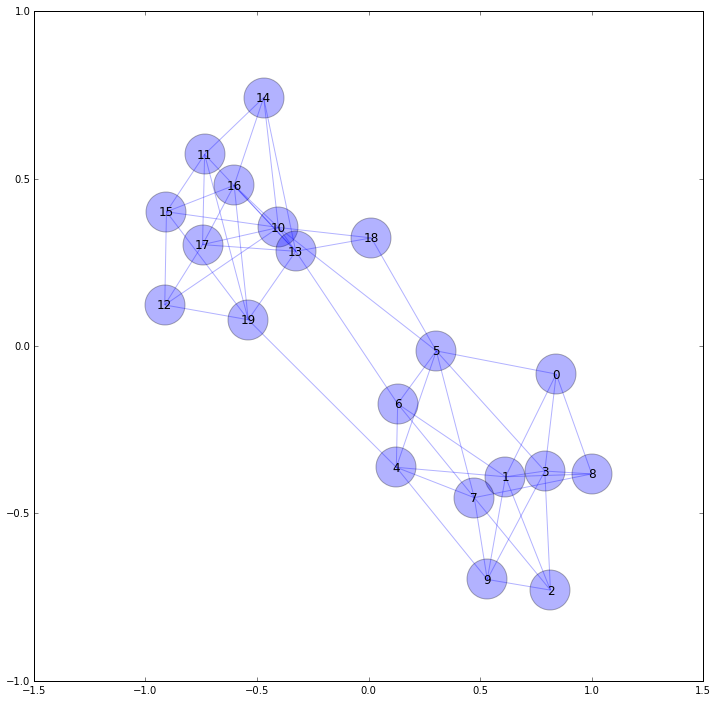

In [5]:
graph = G(20,0.6,0.05)
draw_graph(graph,graph_layout='spring')

### <font color=blue>b. Given a graph (assume that the graph has two communities and satisfies the thresholds outlined above), write a function to find the maximum likelihood estimate of the two communities.  It might be helpful to have a graph stored as an adjacency list. </font>

In [2]:
from collections import defaultdict

def adjacency_list(graph):
    """
    Takes in the current representation of the graph, outputs an equivalent
    adjacenty list
    """
    adj_list = defaultdict(set)
    for node in graph:
        adj_list[node[0]].add(node[1])
        adj_list[node[1]].add(node[0])
    return adj_list

def mle(graph):
    #Your code here
    return None

### <font color=red> b. (Solution)

In [5]:
from collections import defaultdict
import itertools

def adjacency_list(graph):
    """
    Takes in the current representation of the graph, outputs an equivalent
    adjacenty list
    """
    adj_list = defaultdict(set)
    for node in graph:
        adj_list[node[0]].add(node[1])
        adj_list[node[1]].add(node[0])
    return adj_list
        
#Return a list of nodes in the graph
nodes = lambda adj_list: list(adj_list)

#Return a list of possible communities
possible_communities = lambda nodes: set(itertools.combinations(nodes, int(len(nodes)/2)))

#Return the degree of a specific node
deg = lambda node, adj_list: len(adj_list[node]) - 1 #Subtract the self loop

def community_degree(community, adj_list):
    """
    Return the number of edges between nodes in the given community
    """
    total_edges = 0
    for node in community:
        for adjacent_node in adj_list[node]:
            if adjacent_node in community:
                total_edges += 1
    return total_edges

def mle(graph):
    """
    Return two lists of size n/2, one corresponding to each community in the graph
    """
    adj_list = adjacency_list(graph)
    possible_comms = possible_communities(nodes(adj_list))
    max_community = None
    max_connections = 0
    for community in possible_comms:
        cur_degree = community_degree(community, adj_list)
        if cur_degree > max_connections:
            max_connections = cur_degree
            max_community = community
    return max_community

### <font color=blue>c. In the graphs we create, we know that the ground truth is that nodes $(0, \frac{n}{2} - 1)$ and $(\frac{n}{2}, n)$ are the actual communities.  Using this knowledge, please simulate the probability of exact recovery if $\frac{\alpha + \beta}{2} - \sqrt{\alpha \beta} > 1$.  Then do the same if $\frac{\alpha + \beta}{2} - \sqrt{\alpha \beta} < 1$

In [ ]:
def prob_recovery(n, alpha, beta):
    mid = int(n/2)
    ground_truth1 = tuple(np.arange(mid))
    ground_truth2 = tuple(np.arange(mid, n))
    ### Your code here
    return None

#Greater than 1
alpha = 4
beta = 0.25
n = 10
print "Value threshold: ", (alpha + beta)/2 - np.sqrt(alpha * beta)
print "Probability of recovery if threshold bigger than 1: ", prob_recovery(n,alpha,beta)

#Less than 1
alpha = 0.5
beta = 0.25
n = 10
print "Value threshold: ", (alpha + beta)/2 - np.sqrt(alpha * beta)
print "Probability of recovery if threshold bigger than 1: ", prob_recovery(n,alpha,beta)

### <font color=red> c. (Solution)

In [6]:
def prob_recovery(n, alpha, beta):
    mid = int(n/2)
    ground_truth1 = tuple(np.arange(mid))
    ground_truth2 = tuple(np.arange(mid, n))
    largest_sizes = []
    p = (alpha)*np.log(n) / n
    q = (beta)*np.log(n) / n
    num_correct = 0
    for _ in xrange(100):
        graph = G(n,p,q)
        ml_estimate = mle(graph)
        if ml_estimate == ground_truth1 or ml_estimate == ground_truth2:
            num_correct += 1
    return num_correct / 100

#Greater than 1
alpha = 4
beta = 0.25
n = 10
print "Value threshold: ", (alpha + beta)/2 - np.sqrt(alpha * beta)
print "Probability of recovery if threshold bigger than 1: ", prob_recovery(n,alpha,beta)

#Less than 1
alpha = 0.5
beta = 0.25
n = 10
print "Value threshold: ", (alpha + beta)/2 - np.sqrt(alpha * beta)
print "Probability of recovery if threshold bigger than 1: ", prob_recovery(n,alpha,beta)

Value threshold:  1.125
Probability of recovery if threshold bigger than 1:  1.0
Value threshold:  0.0214466094067
Probability of recovery if threshold bigger than 1:  0.03


### <font color=blue>d. In our tests above, we used $n=10$, which is an incredibly small graph size.  We would like to be able to analyze larger graphs, such as where $n=100, 500, 1000$, etc.  What happens when you try to run MLE on a graph of size $n=100$? Why do you think this is happening?

In [ ]:
#Greater than 1
alpha = 4
beta = 0.25
n = 100
print "Value threshold: ", (alpha + beta)/2 - np.sqrt(alpha * beta)
print "Probability of recovery if threshold bigger than 1: ", prob_recovery(n,alpha,beta)

### <font color=red> Solution (d.)
Unless your ML implementation was significantly more efficient than ours, you most likely observed that this simulation either took an extremely large amount of time or did not terminate.  Unfortunately, this is due to the fact that the min-bisection problem is known to be NP-Hard! Luckily, we will see some methods to cope with this later in the lab.

## Thresholds on Exact Recovery: When Will MLE Correctly Recover the Communities?

***NOTE: The results and arguments in this section are due to Abbe et. al$^1$**

Experimentally, we can see that the $\frac{\alpha + \beta}{2}$ is a reasonable threshold for connectivity.  We conjecture that the recovery threshold is then $\frac{\alpha + \beta}{2} > 1 + \sqrt{\alpha \beta}$ where the additional $\sqrt{\alpha \beta}$ term is necessary for recovery.  It turns out that according to this condition, we can find lower and upper bounds on exact recovery in the SBM:

** Lower Bound: Let $\alpha > \beta \ge 0$.  If $\frac{\alpha + \beta}{2} - \sqrt{\alpha \beta} < 1$, then maximum likelihood estimation fails in recovering the communities with probability bounded away from $0$**

** Upper Bound: Let $\alpha > \beta \ge 0$.  If $\frac{\alpha + \beta}{2} - \sqrt{\alpha \beta} > 1$, then the maximum likelihood estimator exactly recovers the communities (up to a global flip) with high probability. **

Using the tools that you have built up this year in EE126, you will prove this lower bound step-by-step.  We will systematically show that the probability Maximum Likelihood fails is bounded away from $0$.  We will provide a chain of logic from the conclusion up, each one thus implying that the probability Maximum Likelihood fails is bounded away from $0$ (specifically that it is $\ge \frac{1}{3}$). 

### <font color=blue>$\mathcal{Q}$2. In this question, we will walk through a proof of the lower bound. Remember, we are trying to show that the probability that Maximum Likelihood Estimation fails is bounded away from $0$.</font>

Before we jump into the math, let's look at a high level view of the approach.  Let's say, as before, that our two communities are Berkeley and Stanford.  MLE will fail when a "traitor" exists.  Here, we define a traitor as some student at Berkeley with more friends at Stanford than at Berkeley, or equivalently, a student at Stanford with more friends at Berkeley than at Stanford:
<img src="http://i.imgur.com/B18F1AQ.png" width="300" height="300" />
<img src="http://i.imgur.com/dwBUppc.png" width="350" height="350" />

We will show that given the condition on $\alpha$ and $\beta$ above, the probability that there is a traitor at Berkeley or Stanford is $\ge \frac{1}{3}$.  It turns out that even though the number of students at Berkeley is $\frac{n}{2}$ and the number of students at Stanford is $\frac{n}{2}$, restricting our traitors to a much smaller "traitor group" of size $\frac{n}{\log^{3}{n}}$ is sufficient to show the lower bound.  In this question, you will prove three crucial lemmas instrumental in showing the lower bound.  Each of the three lemmas builds upon the previous.  We will prove:
- #### Lemma 1: $P(\text{Student i in Berkeley's traitor group is a traitor}) > \frac{\ln{10}\log{n}}{n\log{\log{n}}}$ implies that $P(\text{There is a traitor in Berkeley's traitor group}) \ge \frac{9}{10}$
- #### Lemma 2: $P(\text{There is a traitor in Berkeley's traitor group}) \ge \frac{9}{10}$ implies that $P(\text{There is a traitor at Berkeley}) \ge \frac{2}{3}$
- #### Lemma 3: $P(\text{There is a traitor at Berkeley}) \ge \frac{2}{3}$ implies that $P(\text{MLE Fails}) \ge \frac{1}{3}$


### <font color=blue>a. In this part we will prove Lemma 3. Let $F$ be the event that maximum likelihood fails.  Additionally, let $T_B$ be the event that there is a traitor at Berkeley (ie that there is a student at Berkeley with more friends at Stanford than at Berkeley).  Show that:
$$P(T_B) \ge \frac{2}{3} \implies P(F) \ge \frac{1}{3}$$
</font>

### <font color=red>a. Solution
Let $T_S$ be the event that there is a traitor at Stanford.  Note that:
$$P(T_B \cup T_S) = P(T_B) + P(T_S) - P(T_B \cap T_S) \le 1$$
We are given that $P(T_B) \ge \frac{2}{3}$.  Thus, by symmetry we have that $P(T_S) \ge \frac{2}{3}$.  Plugging these in to the above inequality, we see that $P(T_B \cap T_S) \ge \frac{1}{3}$.  We see that the event $T_B \cap T_S$ is equivalent to $F$ (if there is a student at Berkeley with more friends at Stanford than at Berkeley and a friend at Stanford with more friends at Berkeley than at Stanford, maximum likelihood will switch them and recovery will fail).

----------------------------------------------------------------------------------------------------------------------

You have just successfully shown the last bullet in the list of three lemmas above.  It is now time to consider Berkeley's traitor group.  Remember that this group is not necessarily full of traitors; rather, when we are searching for traitors, we may restrict our search to this group which is much smaller than the size of the set of all Berkeley students.  Also remember that the size of such a group, let's call it $T$, is $\frac{n}{\log^{3}{n}} = \frac{n}{\gamma(n)}$ where $\gamma(n) = \log^3{n}$ is introduced for notational convenience.  Now, the traitor group has one more nice feature.  Let $A$ be the event that no student in the traitor group has more than $\delta(n) = \frac{\log{n}}{\log{\log{n}}}$ friends in $T$ (this function should look familiar to a term in Lemma 1!). It turns out that $P(A) \ge \frac{9}{10}$.  

Why does this event happen with such high probability? Note that the expected number of friends of a node within the traitor group is $\frac{n}{\log^{3}{n}} \times \frac{\alpha \log{n}}{n} = \frac{\alpha}{\log^2{n}}$. Thus, the event of having more than $\frac{\log{n}}{\log\log{n}}$ friends within $T$ is so rare that this event won't happen to any of the nodes in $T$ with high probability. 

This fact gives some hint as to why the traitor group is so special and should come in handy in the next part.  Note that the proof of this fact requires a sharp analysis of the tail event, so we will just accept it as a fact.
<img src="http://i.imgur.com/4BKi9hW.png" width="400" height="400" />
(Note that the diagram above is rough and the number of nodes/edges are not exact, it is just to give you a rough visual of what is going on).

### <font color=blue>b. In this part, we will prove Lemma 2.  Remember that some student $i \in T$ is a traitor if $i$ has more friends at Stanford than at Berkeley (note that $i$ is a Berkeley student).  We will look at a slightly more specific event: Let $F_T^{(i)}$ be the event that the sum of $\delta(n)$ and the number of friends $i$ has at Berkeley outside of $T$ is less than the number of friends $i$ has at Stanford.  Also, let $F_t = \cup_{i \in T} F_T^{(i)}$. Show that $P(F_T) \ge \frac{9}{10} \implies P(F) \ge \frac{1}{3}$
Hint: Try to use part a.






### <font color=red>b. Solution
Note that $A \cap F_T \implies T_B$. We see that 
$$P(T_B) \geq P(F_T \cap A) = P(F_T) + P(A) - P(F_T \cap A) \ge P(F_T) + P(A) - 1 \ge \frac{8}{10} > \frac{2}{3}$$
And we are done. 

### <font color=blue>c. In this part, we will prove Lemma 1. Show that for sufficiently large $n$, if $P(F_T^{(i)}) > n^{-1}\gamma(n)\ln{10}$, then $P(F_T) \ge \frac{9}{10}$
Hint: Try using the complement and then try to use part b.

### <font color=red>c. Solution
As $F_T^{i}$ are iid,

$$P\left(F_T\right)=P\left(\cup_{i \in T} F_T^{i}\right) = 1 - P\left(\cap_{i \in T} \left(F_T^{(i)}\right)^{C}\right) = 1 - \left(1 - P\left(F_T^{(i)}\right)\right)^{|T|}$$

Note that $|T| = \frac{n}{\gamma(n)}$.  Thus, we would like to show that:
$$\lim_{n \rightarrow \infty}( 1 - P(F_T^{(i)}))^{\frac{n}{\gamma(n)}} \le \frac{1}{10}$$

Note that by definition of $e$, $e = \lim_{n \rightarrow \infty}(1 - P(F_T^{(i)}))^{-\frac{1}{P(F_T^{(i)})}}$.  Thus, the LHS becomes $\lim_{n \rightarrow \infty}\text{exp}(-P(F_T^{(i)})\frac{n}{\gamma(n)})$ by the criteria in the problem statement, this is $\le \frac{1}{10}$ and we are done.

To finish the proof, we need to show that $P(F_T^{i}) > n^{-1}\gamma(n)\ln{10}$ in order to use the result of part c. 
### <font color=blue>d. Show that if $Z_1,Z_2,...,Z_n \sim \text{Bernoulli}(\frac{\beta\log{n}}{n}), W_1,...,W_N \sim \text{Bernoulli}(\frac{\alpha\log{n}}{n})$:
$$P(F_T^{(i)}) = P\biggl(\sum_{j=1}^{\frac{n}{2}} Z_j - \sum_{j=1}^{\frac{n}{2}-\frac{n}{\gamma(n)}}W_j \ge \frac{\log{n}}{\log{\log{n}}}\biggr) \ge P\biggl(\sum_{j=1}^{\frac{n}{2}} Z_j - \sum_{j=1}^{\frac{n}{2}}W_j \ge \frac{\log{n}}{\log{\log{n}}}\biggr)$$

### <font color=red>d. Solution
Note that the $Z_j$ denote friendships between student $i$ at Berkeley and students at Stanford. Additionally, $W_j$ denote friendships between student $i$ and students at Berkeley not in $T$. The first equality thus follows by definition of $F_T^{(i)}$. The inequality follows from the nonnegativity of the $W_j$.

#### To finish, we use the inequality 
$$-\log{P\biggl(\sum_{j=1}^{N} Z_j - \sum_{j=1}^{N}W_j \ge \epsilon\biggr)} \le (\frac{\alpha + \beta}{2} - \sqrt{\alpha \beta})\log{n} + o(\log{n})$$ applied to the result of part d. and the result follows.  Phew! That was a lot of math... Using similar techniques, we can show the upper bound. Now that we've gotten this under our belt, let's revisit the implementation of recovery and see if we can be more efficient than ML.

## Efficient Algorithm for Community Detection
In the previous parts, we used the maximum likelihood decoder to reconstruct the two communities. As we saw in one of the previous questions, maximum likelihood is extremely inefficient.  In this section, we will develop a more efficient algorithm for the community detection problem. We will use $G(V, E)$ to denote the undirected graph that we observe, where $V$ is the set of nodes $(|V|=n)$, and $E$ is the set of edges.

First, let's consider an intuitive algorithm to solve the community detection problem. As we have seen, the goal of community detection is to separate the nodes into two communities, such that the number of edges within the same community is as large as possible and the number of edges between two communities is as small as possible. To achieve this goal, we consider the "score" of a particular separation. For an edge within a community, we get one point; for an edge between two communities, we get minus one point. We want to maximize the score over all possible separations. We identify a choice of communities by a vector $x\in\mathbb{R}^n$ with $\pm1$ entries such that $x_i$ will be $+1$ if node $i$ is in one community and $-1$ if it is in the other. We also define $A$ as the $n\times n$ matrix with zero diagonal whose non diagonal entries are given by
$$
A_{ij}=\begin{cases}
1 & \text{if }(i,j)\in E\\
-1 & \text{if }(i,j)\notin E
\end{cases}
$$
Then we can show that, maximizing the score is equivalent to the following optimization problem (think about the reason by yourself):
\begin{align}
\max &~~x^TAx \\
s.t. &~~x_i=\pm1.
\end{align}
However, since this optimization problem is combinatorial and hard to solve, we need to relax the constraint that $x_i$ has to be $\pm1$.

Let's look at the objective of the optimization problem:
$x^TAx$. According to knowledge in linear algebra, we know that $x^TAx=\text{Tr}(x^TAx)=\text{Tr}(Axx^T)$. Here, "Tr" denotes the trace of a square matrix, i.e., the sum of all the elements on the diagonal. We can see that $x^TAx=\text{Tr}(x^TAx)$ is obvious because the trace of a scalar is still itself; and $\text{Tr}(x^TAx)=\text{Tr}(Axx^T)$ is because of the fact that $\text{Tr}(AB)=\text{Tr}(BA)$. If we denote the rank-one matrix $xx^T$ by $X$, then the previous optimization problem is equivalent to:
\begin{align}
\max &~~\text{Tr}(AX) \\
s.t. &~~X=xx^T\text{ and }x_i=\pm1.
\end{align}

Since this problem is still hard to solve, we need to relax the constraints on $X$. As we can see, the diagonal elements of $X$ are all 1. Further, we can see that $X$ is positive semidefinite.
(A matrix $D\in\mathbb{R}^{n\times n}$ is called a positive semidefinite matrix if and only if for any vector $u\in\mathbb{R}^n$, there is $u^TDu\ge 0$). 
An optimization problem with linear objective functions and matrix variables which are constrained to be positive semidefinite is called a semidefinite program (SDP). SDPs are convex optimization problems, and therefore, the global minimum can be found in polynomial time. Therefore, instead of solving the combinatorial optimization problem, we solve the following SDP problem:
\begin{align*}
\max &~~\text{Tr}(AX)\\
s.t. &~~X_{ii}=1\\
&X\succeq 0,
\end{align*}
and hope the the relaxed optimization problem can give us the same answer as the original problem. It is proved that if $\alpha$ and $\beta$ satisfy some conditions, the solution to the SDP problem $X^*$ will be the outer product of the solution to the combinatorial optimization problem $x^*$, i.e., $X^*=x^*x^{*T}$. We will use the CVX package for Python to solve this SDP:

http://cvxopt.org/.

Install CVX in your computer and read the instructions on solving SDP using CVX:

http://cvxopt.org/userguide/coneprog.html#semidefinite-programming.

Specifically, we will solve the dual SDP problem. We will use different data structures from the previous parts in order to use CVX. Therefore, we define some new functions which are useful in this part.

### <font color=blue>$\mathcal{Q}$3. In this question we will simulate reconstruction using the semidefinite programming algorithm and use this to plot the thresholds on reconstruction.

### <font color=blue>a.  Let alpha and beta vary between $0$ and $5$.  Make two separate 3-d plots.  Let the first plot the value of $\frac{\alpha + \beta}{2} - \sqrt{\alpha \beta}$ and let the second plot the value of the probability of recovery.

In [ ]:
import matplotlib.pyplot as plt

#Plotting the probability of recovery
n = 10
fig = plt.figure()
ax = fig.gca(projection='3d')
alpha = np.arange(0, 5, 0.2)
beta = np.arange(0, 5, 0.2)
alpha, beta = np.meshgrid(alpha, beta)
recovery = lambda a,b: recon_prob_sdp(n, a, b)
recovery = np.vectorize(recovery)
connected = recovery(alpha, beta)
surf = ax.plot_surface(alpha, beta, connected, rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.view_init(azim = 45,elev = 15)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=2)
ax.set_title('Probability of Recovery')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')

plt.show()

### <font color=red>b. (Solution)

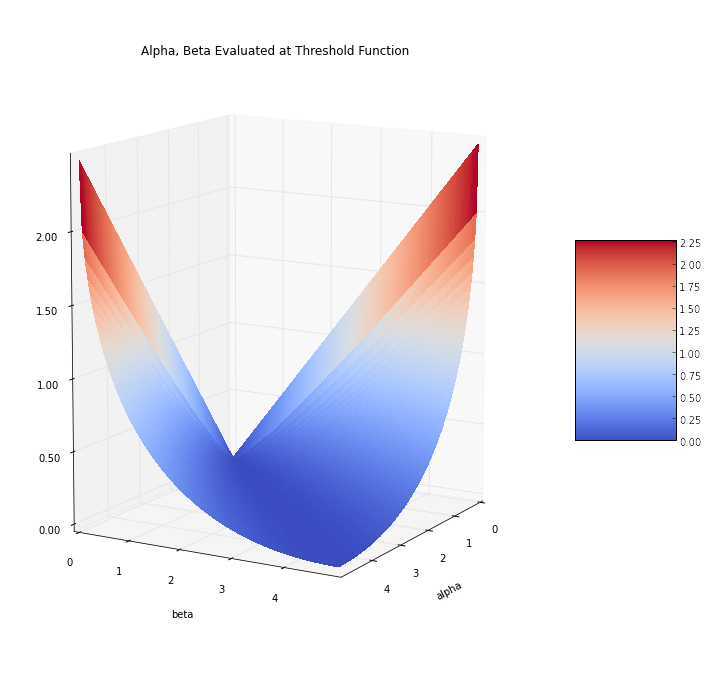

In [80]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')
alpha = np.arange(0, 5, 0.05)
beta = np.arange(0, 5, 0.05)
alpha, beta = np.meshgrid(alpha, beta)
thresh = (alpha + beta)/2 - np.sqrt(alpha * beta)
surf = ax.plot_surface(alpha, beta, thresh, rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.view_init(azim = 30,elev = 10)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=2)
ax.set_title('Alpha, Beta Evaluated at Threshold Function')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')

plt.show()

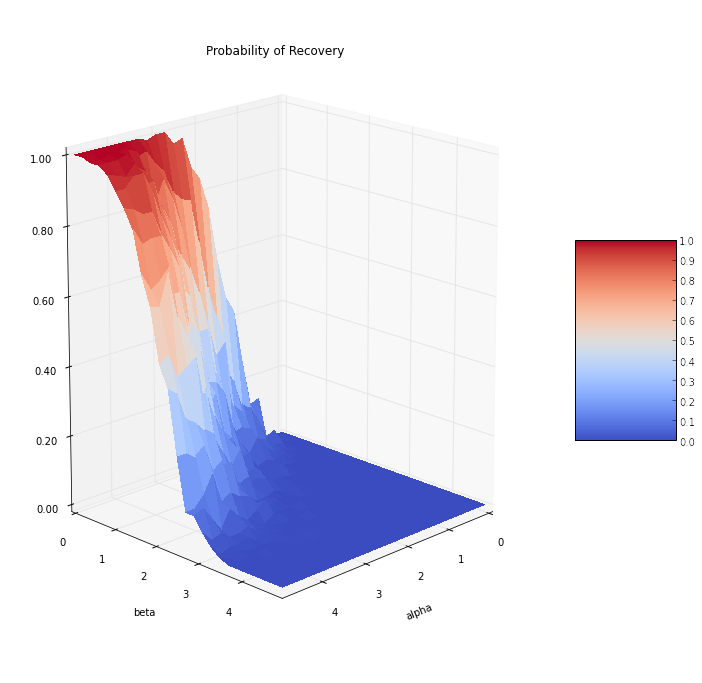

In [81]:
fig = plt.figure()
ax = fig.gca(projection='3d')
alpha = np.arange(0, 5, 0.2)
beta = np.arange(0, 5, 0.2)
alpha, beta = np.meshgrid(alpha, beta)
recovery = lambda a,b: prob_recovery(10,a,b)
recovery = np.vectorize(recovery)
connected = recovery(alpha, beta)
surf = ax.plot_surface(alpha, beta, connected, rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.view_init(azim = 45,elev = 15)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=2)
ax.set_title('Probability of Recovery')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')

plt.show()

### <font color=red> Using SDP:

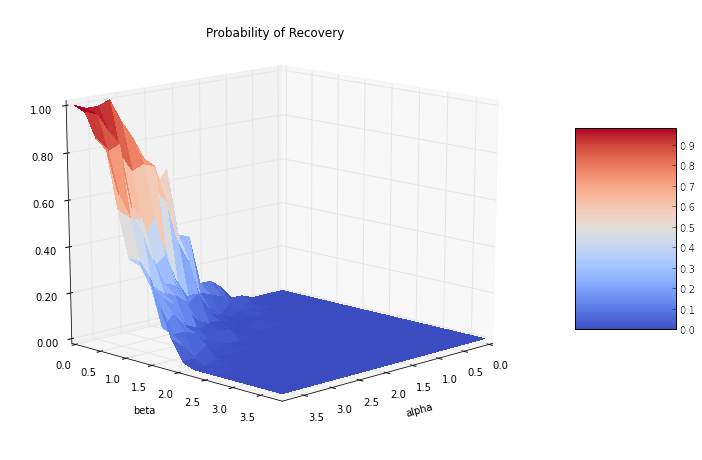

In [5]:
import matplotlib.pyplot as plt
n = 10
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
alpha = np.arange(0, 4, 0.2)
beta = np.arange(0, 4, 0.2)
alpha, beta = np.meshgrid(alpha, beta)
recovery = lambda a,b: recon_prob_sdp(n, a, b)
recovery = np.vectorize(recovery)
connected = recovery(alpha, beta)
surf = ax.plot_surface(alpha, beta, connected, rstride=1, cstride=1, cmap=cm.coolwarm,
        linewidth=0, antialiased=False)
ax.view_init(azim = 45,elev = 15)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=2)
ax.set_title('Probability of Recovery')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')

plt.show()

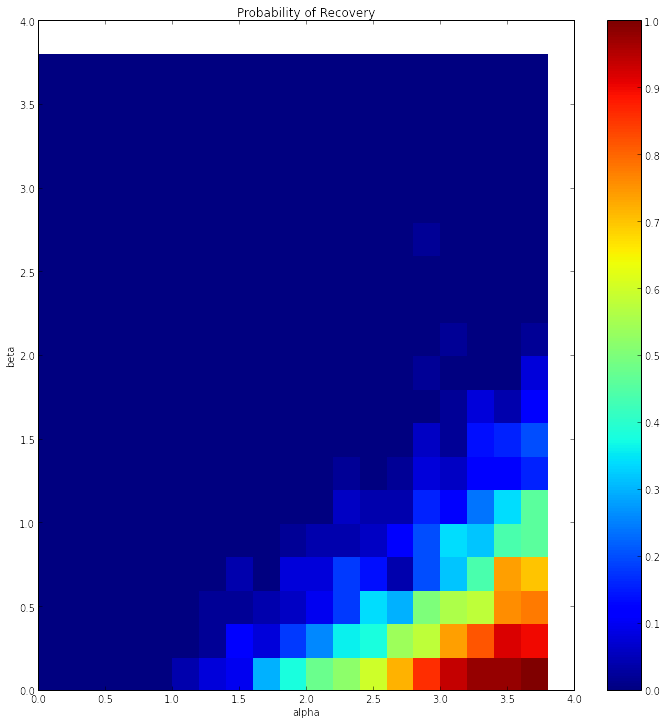

In [16]:
from matplotlib.colors import LogNorm
n = 10
fig = plt.figure()
alpha = np.arange(0, 4, 0.2)
beta = np.arange(0, 4, 0.2)
alpha, beta = np.meshgrid(alpha, beta)
recovery = lambda a,b: recon_prob_sdp(n, a, b)
recovery = np.vectorize(recovery)
connected = recovery(alpha, beta)
thresh = (alpha + beta)/2 - np.sqrt(alpha * beta)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Probability of Recovery')
plt.pcolormesh(alpha, beta, connected)
plt.colorbar()
plt.show()

### An Interesting Viewpoint
** The stochastic block model can be seen as a code on a discrete memoryless channel. **  In this view, we can consider the the community assignment vector $x \in \{0,1\}^n$ as the "message" to be transmitted (the value of each $x_i$ tells us which community it belongs to).  The output of this channel is $y \in \{0,1\}^{\frac{n(n-1)}{2}}$ where $y_{ij}$ is the output of $x_i + x_j \hspace{1.4mm} \text{mod}(2)$ through the channel:
$$
\begin{bmatrix}
1- p & p \\
1-q & q
\end{bmatrix}
$$
In other words, when we are sending the vector $x$ across the channel, we take every pair of nodes $x_i, x_j$, both of which are either $0$ or $1$.  We take the XOR of the two nodes, call it $x_{ij}$ and send it through the channel matrix described above.  Note that if $x_{ij} = 0$, then $x_i$ and $x_j$ are in the same community, and if $x_{ij} = 1$, then $x_i$ and $x_j$ are in different communities.  This channel matrix describes the following scenario: if $x_{ij} = 0$, then the channel output $y_{ij} = 0$ with probability $1-p$ and $1$ with probability $p$.  If $x_{ij} = 1$, then the channel outputs $y_{ij} = 0$ with probability $1-q$ and outputs $1$ with probability $q$.  The output matrix elements $y_{ij} = 1$ if there is an edge between node $x_i$ and $x_j$ in the graph.  The following picture summarizes the setup:

<img src="http://i.imgur.com/Xmzzbup.png" width="800px" height="800px"/>

## References
[1] E. Abbe, A. S. Bandeira, and G. Hall. Exact Recovery in the Stochastic Block Model. available at arXiv:1405.3297 [cs.SI], 2014.